In [1]:
pip install DeepXDE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf


x_lower = -200
x_upper = 200
t_lower = 0
t_upper = 10

α = 0.3
β = 0

α_0 = 0.3
k = 1
ω = 0.88
x_0 = -30
θ_0 = 0
μ = 4 * (k ** 2 - ω)

x = np.linspace(x_lower, x_upper, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = -v_t + u_xx + u * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)
    f_v = u_t + v_xx + v * (u ** 2 + v ** 2) * (1 - α * (u ** 2 + v ** 2) + β * (u ** 2 + v ** 2) ** 2)

    return [f_u, f_v]


bc_u_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.icbc.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)


def init_cond_u(x):
    exp1 = np.exp(np.float128((x[:, 0:1] - x_0) * np.sqrt(μ)))
    exp2 = np.exp(np.float128(2 * (x[:, 0:1] - x_0) * np.sqrt(μ)))

    return np.cos(k * x[:, 0:1] + θ_0) * np.sqrt(μ * exp1 / (
                ((1 / 2) * exp1 + 1) * ((1 / 2) * exp1 + 1) - (α_0 * μ / 3) * exp2))


def init_cond_v(x):
    exp1 = np.exp(np.float128((x[:, 0:1] - x_0) * np.sqrt(μ)))
    exp2 = np.exp(np.float128(2 * (x[:, 0:1] - x_0) * np.sqrt(μ)))

    return np.sin(k * x[:, 0:1] + θ_0) * np.sqrt(μ * exp1 / (
                ((1 / 2) * exp1 + 1) * ((1 / 2) * exp1 + 1) - (α_0 * μ / 3) * exp2))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v],
    num_domain=30000,
    num_boundary=500,
    num_initial=3000,
    train_distribution="pseudo"
)

# предобработка входа


def input_transform(input_data):
    x1 = tf.cos(2 * np.pi * (input_data[:, 0:1] - x_lower) / (x_upper - x_lower))
    x2 = tf.sin(2 * np.pi * (input_data[:, 0:1] - x_lower) / (x_upper - x_lower))
    t = input_data[:, 1:2]

    return tf.concat([x1, x2, t], axis=1)


net = dde.nn.FNN([2] + [32] * 4 + [2], "sin", "Glorot normal")

net.apply_feature_transform(input_transform)

model = dde.Model(data, net)

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=5e-3,
    decay_steps=100,
    decay_rate=0.019,
    staircase=False
)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=5e-3)

model.compile(optimizer=opt, lr=lr_schedule, loss="MSE")
model.train(iterations=50000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.066243 s



/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
/home/jupyter/.local/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.102797 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [4.22e-02, 3.81e-02, 1.68e-14, 7.78e-19, 1.91e-14, 1.38e-18, 4.51e-03, 2.99e-01]    [4.22e-02, 3.81e-02, 1.68e-14, 7.78e-19, 1.91e-14, 1.38e-18, 4.51e-03, 2.99e-01]    []  
1000      [1.06e-06, 9.21e-07, 7.09e-15, 9.53e-20, 3.57e-15, 3.68e-20, 1.96e-03, 1.66e-03]    [1.06e-06, 9.21e-07, 7.09e-15, 9.53e-20, 3.57e-15, 3.68e-20, 1.96e-03, 1.66e-03]    []  
2000      [3.22e-07, 2.33e-07, 7.98e-15, 7.09e-20, 3.99e-15, 2.95e-20, 1.96e-03, 1.66e-03]    [3.22e-07, 2.33e-07, 7.98e-15, 7.09e-20, 3.99e-15, 2.95e-20, 1.96e-03, 1.66e-03]    []  
3000      [1.38e-07, 1.06e-07, 5.78e-15, 5.66e-20, 4.25e-15, 2.61e-20, 1.96e-03, 1.66e-03]    [1.38e-07, 1.06e-07, 5.78e-15, 5.66e-20, 4.25e-15, 2.61e-20, 1.96e-03, 1.66e-03]    []  
4000      [8.60e-08, 6.82e-08, 5

(<deepxde.model.LossHistory at 0x7fc2ae8ce4d0>,
 <deepxde.model.TrainState at 0x7fc2ae8ce170>)

In [4]:
model.compile("L-BFGS", lr=dde.optimizers.set_LBFGS_options(maxcor=50, ftol=2.220446049250313e-16, gtol=1e-08, maxiter=10000, maxfun=10000, maxls=50), loss="MSE")
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 1.311088 s

Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
50000     [5.97e-05, 5.58e-05, 2.47e-15, 1.22e-17, 1.83e-15, 3.84e-17, 1.77e-04, 2.20e-04]    [5.97e-05, 5.58e-05, 2.47e-15, 1.22e-17, 1.83e-15, 3.84e-17, 1.77e-04, 2.20e-04]    []  
51000     [4.47e-06, 4.06e-06, 5.39e-15, 2.37e-17, 3.79e-15, 5.84e-18, 1.14e-06, 1.08e-06]    [4.47e-06, 4.06e-06, 5.39e-15, 2.37e-17, 3.79e-15, 5.84e-18, 1.14e-06, 1.08e-06]        
52000     [1.48e-06, 1.47e-06, 1.03e-14, 1.50e-17, 6.24e-15, 7.51e-18, 4.61e-07, 4.33e-07]    [1.48e-06, 1.47e-06, 1.03e-14, 1.50e-17, 6.24e-15, 7.51e-18, 4.61e-07, 4.33e-07]        
53000     [7.25e-07, 7.79e-07, 1.15e-14, 3.03e-17, 8.07e-15, 1.01e-17, 2.58e-07, 2.15e-07]    [7.25e-07, 7.79e-07, 1.15e-14, 3.03e-17, 8.07e-15, 1.01e-17, 2.58e-07, 2.15e-07]        
54000     [4.

(<deepxde.model.LossHistory at 0x7fc2ae8ce4d0>,
 <deepxde.model.TrainState at 0x7fc2ae8ce170>)

x     t    pred_u  ...        true_u        true_v        true_h
0     -200.000000   0.0 -0.000038  ...  8.970843e-27  1.608048e-26  1.841353e-26
1     -198.431373   0.0 -0.000046  ... -2.765431e-26  1.550629e-26  3.170499e-26
2     -196.862745   0.0 -0.000036  ... -2.680243e-26 -4.755804e-26  5.459064e-26
3     -195.294118   0.0  0.000010  ...  8.178665e-26 -4.632677e-26  9.399588e-26
4     -193.725490   0.0  0.000082  ...  8.007212e-26  1.406495e-25  1.618451e-25
...           ...   ...       ...  ...           ...           ...           ...
51451  193.725490  10.0 -0.000486  ... -3.144222e-31  1.436212e-31  3.456709e-31
51452  195.294118  10.0 -0.000413  ... -8.380776e-32 -1.824279e-31  2.007577e-31
51453  196.862745  10.0 -0.000284  ...  1.058441e-31 -4.890329e-32  1.165955e-31
51454  198.431373  10.0 -0.000128  ...  2.853516e-32  6.141006e-32  6.771596e-32
51455  200.000000  10.0  0.000031  ... -3.562952e-32  1.664988e-32  3.932787e-32

[51456 rows x 8 columns]

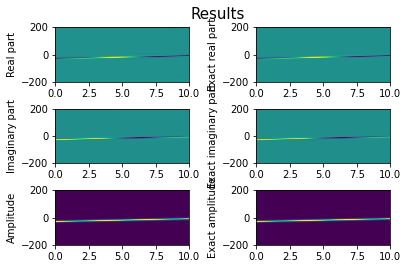

In [5]:
prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)


def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
                ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
            2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


def q_exact(x, t):
    return np.sqrt(μ * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) / (
            ((1 / 2) * np.exp((x - 2 * k * t - x_0) * np.sqrt(μ)) + 1) ** 2 - (α_0 * μ / 3) * np.exp(
        2 * (x - 2 * k * t - x_0) * np.sqrt(μ))))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data_pred2_200.orc')
display(df)

fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()